In [1]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
from IPython.display import display
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.modules.activation import ReLU
from torch.optim import Adam
from tqdm import tqdm_notebook
from torchvision.utils import save_image
import matplotlib
import math
from inspect import isfunction
from functools import partial
import scipy
from scipy.special import rel_entr
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from einops.layers.torch import Rearrange
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.animation as animation
import matplotlib.image as mpimg
import glob
from PIL import Image
from itertools import product
import random
from scipy.stats import pearsonr

%matplotlib inline

In [3]:
# load data
nat_seq_name = "data/promoter_2.npy"
syn_seq_name = "syn_seq/promoter_2/new_seq_epoch_29.npy"

nat_seq = np.load(nat_seq_name, allow_pickle=True)
nat_seq = nat_seq.tolist()

syn_seq = np.load(syn_seq_name, allow_pickle=True)
syn_seq = syn_seq.tolist()


In [4]:
# sample num
sample_num = 1000

In [5]:
# count GC content
def gc_content(seq):
    ret = []
    for s in seq:
        ret.append((s.count('G')+s.count('C'))*100/len(s))
    return ret

In [6]:
nat_sample = random.sample(nat_seq, sample_num)
syn_sample = random.sample(syn_seq, sample_num)

ret_nat = gc_content(nat_sample)
ret_syn = gc_content(syn_sample)

ret_dict = {'synthetic': ret_nat, 'nature': ret_syn}
ret = pd.DataFrame(ret_dict)

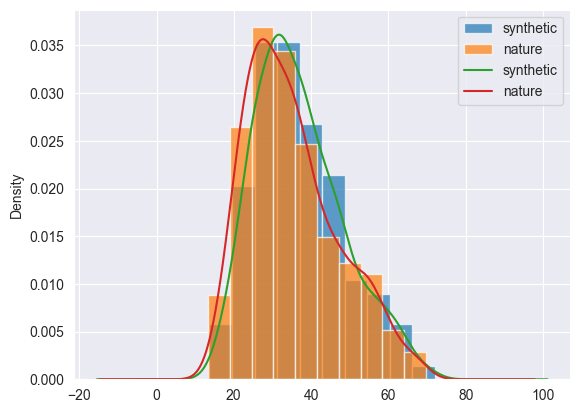

In [7]:
# draw GC content
syn_count = pd.Series(ret['synthetic'])
nat_count = pd.Series(ret['nature'])
plt.hist(syn_count,density = True,edgecolor ='w',alpha = 0.7,label = 'synthetic')
plt.hist(nat_count,density = True,edgecolor ='w',alpha = 0.7,label = 'nature')
syn_count.plot(kind = 'kde',label = 'synthetic')
nat_count.plot(kind = 'kde',label = 'nature')
# 显示图例
plt.legend()
# 显示图形
plt.show()

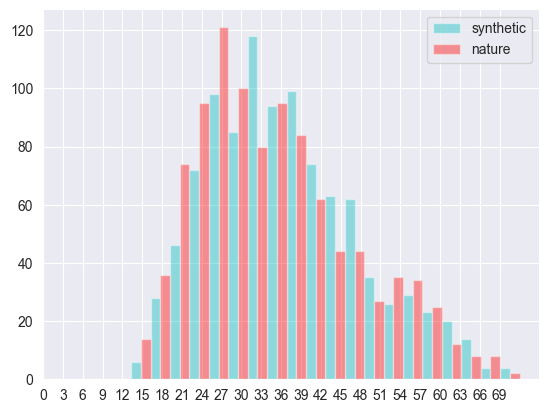

In [8]:
plt.hist(x = ret,            # 绘图数据
        bins = 20,            # 指定直方图的条形数为20个
        edgecolor = 'w',      # 指定直方图的边框色
        color = ['c','r'],    # 指定直方图的填充色
        label = ['synthetic','nature'],     # 为直方图呈现图例
        density = False,      # 是否将纵轴设置为密度，即频率
        alpha = 0.4,          # 透明度
        rwidth = 1,           # 直方图宽度百分比：0-1
        stacked = False)      # 当有多个数据时，是否需要将直方图呈堆叠摆放，默认水平摆放
ax = plt.gca()                # 获取当前子图
ax.spines['right'].set_color('none')  # 右边框设置无色
ax.spines['top'].set_color('none')    # 上边框设置无色
plt.xticks(np.arange(0,72,3))
# 显示图例
plt.legend()
# 显示图形
plt.savefig('gc_contenr.png', dpi=300)
plt.show()

In [9]:
ret

,synthetic,nature
0,26.785714,28.484848
1,30.357143,47.878788
2,20.833333,46.666667
3,61.309524,31.515152
4,50.595238,69.696970
...,...,...
995,48.214286,24.848485
996,32.738095,34.545455
997,29.761905,18.181818
998,63.095238,26.060606


In [10]:
# extract k-mers
def get_k_mers(sequences, k):
    list = []
    # 先遍历所有seq并提取所有子序列，得到len(sequences)*len(sequences[i])-k+1个k_mers
    for i in range(len(sequences)):
        for j in range(len(sequences[i])-k+1):
            list.append(sequences[i][j:j+k])
    return list

In [11]:
# get all k-mers
def nucleotide_type(k):
    z = []
    for i in product('ACGT', repeat = k):  #笛卡尔积（有放回抽样排列）
        z.append(''.join(i))  #把('A,A,A')转变成（AAA）形式
    return z

In [12]:
def fea(sequences, k):
    char = nucleotide_type(k)
    k_mers = get_k_mers(sequences, k)
    list = []
    for i in range(4**k):
        n = 0
        for k_mer in k_mers:
            if k_mer == char[i]:
                n += 1
        list.append(n)
    return list

In [13]:
def fre_fea(sequences, k):
    char = nucleotide_type(k)
    k_mers = get_k_mers(sequences, k)
    list = []
    for i in range(4**k):
        n = 0
        for k_mer in k_mers:
            if k_mer == char[i]:
                n += 1
        list.append(n/len(k_mers))
    return list

In [14]:
def count_k_mer(nat_seq_name, syn_seq_name, max_mer_len):
    nat_seq = np.load(nat_seq_name, allow_pickle=True)
    nat_seq = nat_seq.tolist()

    syn_seq = np.load(syn_seq_name, allow_pickle=True)
    syn_seq = syn_seq.tolist()

    nat_k_mer_freq = [fea(nat_seq, i) for i in range(2, max_mer_len+1)]
    syn_k_mer_freq = [fea(syn_seq, i) for i in range(2, max_mer_len+1)]

    fea_dict_df = [pd.DataFrame({"nature": nat_k_mer_freq[i], "synthetic": syn_k_mer_freq[i]}) for i in range(max_mer_len-1)]
    k_mer_r2_list = []

    for i in range(max_mer_len - 1):
        k_mer_r2_list.append(pearsonr(fea_dict_df[i]['nature'], fea_dict_df[i]['synthetic']))
    return fea_dict_df, k_mer_r2_list


In [12]:
k_mer_1, k_mer_pcc_1 = count_k_mer("data/promoter_1.npy", "syn_seq/promoter_1/new_seq_epoch_{}.npy".format(79),6)

In [15]:
k_mer_2, k_mer_pcc_2 = count_k_mer("data/promoter_2.npy", "syn_seq/promoter_2/new_seq_epoch_{}.npy".format(29),6)

In [16]:
k_mer_3, k_mer_pcc_3 = count_k_mer("data/promoter_3.npy", "syn_seq/promoter_3/new_seq_epoch_{}.npy".format(109),6)

In [54]:
for i in range(5):
    k_mer_3[i]['nature'] =  k_mer_3[i]['nature'] / np.sum(k_mer_3[i]['nature'])
    k_mer_3[i]['synthetic'] =  k_mer_3[i]['synthetic'] / np.sum(k_mer_3[i]['synthetic'])

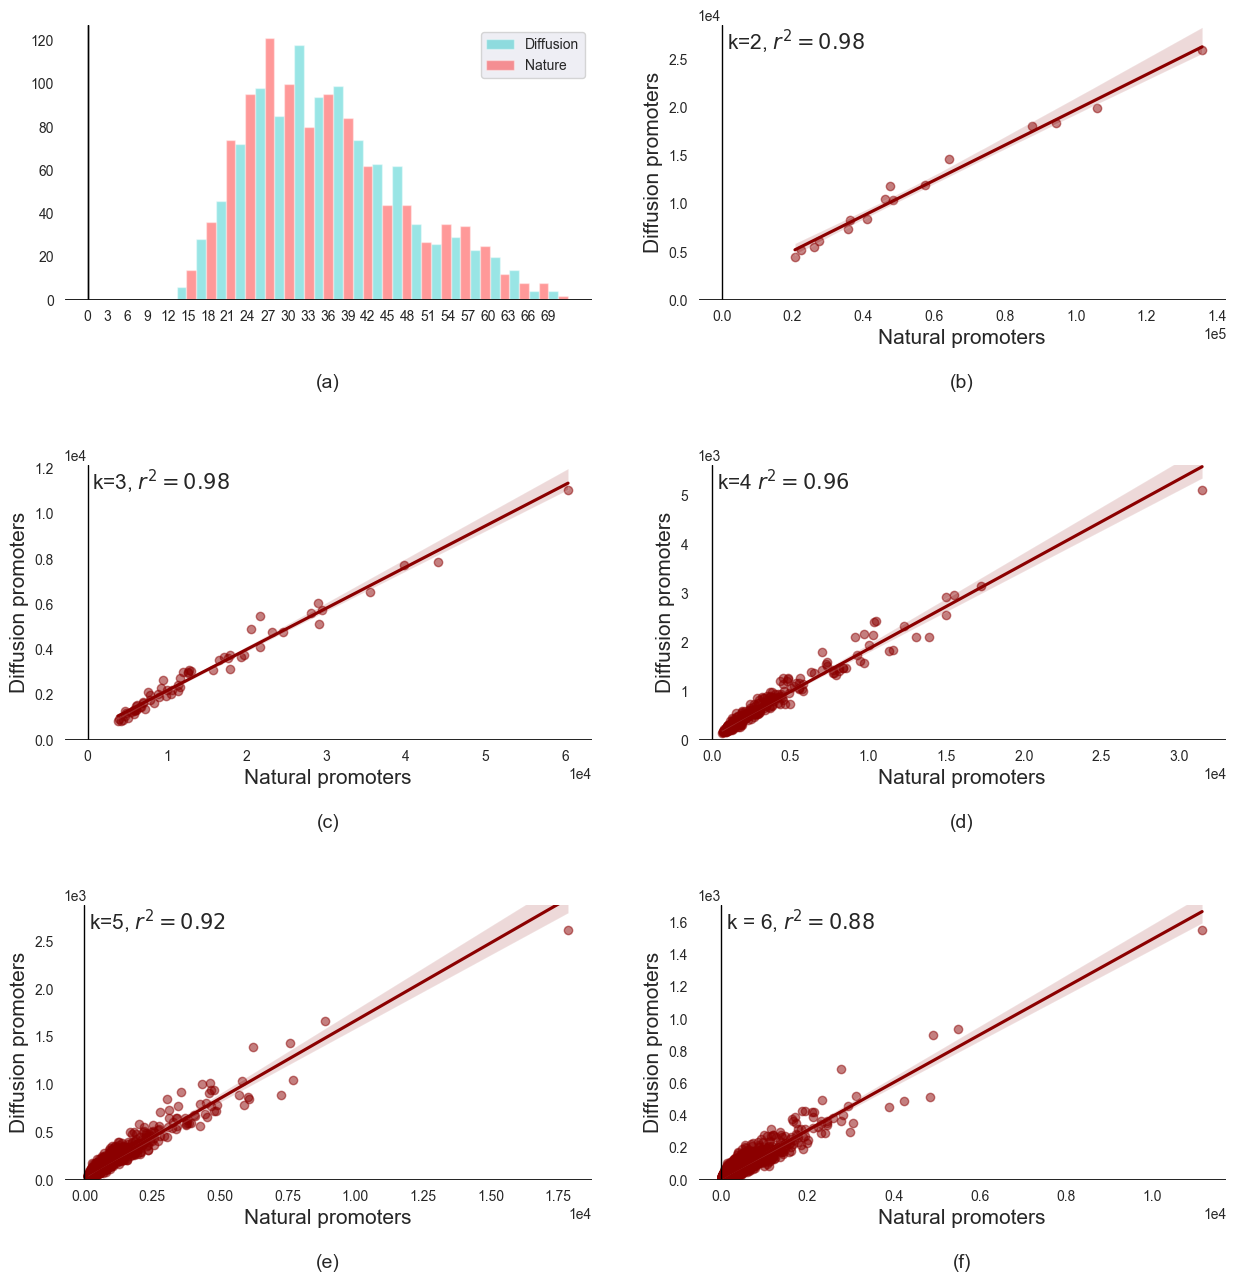

In [24]:
plt.figure(facecolor='white')
# plt.figure(figsize=(11, 9), facecolor='white')
plt.subplot(321)
plt.hist(x = ret,            # 绘图数据
        bins = 20,            # 指定直方图的条形数为20个
        edgecolor = 'w',      # 指定直方图的边框色
        color = ['c','r'],    # 指定直方图的填充色
        label = ['Diffusion','Nature'],     # 为直方图呈现图例
        density = False,      # 是否将纵轴设置为密度，即频率
        alpha = 0.4,          # 透明度
        rwidth = 1,           # 直方图宽度百分比：0-1
        stacked = False)      # 当有多个数据时，是否需要将直方图呈堆叠摆放，默认水平摆放
ax = plt.gca()                # 获取当前子图
ax.spines['right'].set_color('none')  # 右边框设置无色
ax.spines['top'].set_color('none')    # 上边框设置无色
ax.axhline(linewidth=1, color='black')
ax.axvline(linewidth=1, color='black')
ax.set_facecolor('white')
plt.xticks(np.arange(0,72,3))
plt.tick_params(labelsize=10)
# 显示图例
plt.legend()
ax.set_title('(a)', y=-0.35, fontsize=14)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)

plt.subplot(326)
plt.rcParams["figure.figsize"] = (15, 15)
sns.regplot(x='nature', y='synthetic', data=k_mer_3[4], scatter_kws={'marker': 'o', 'alpha': 0.5}, color='darkred')
plt.xlabel('Natural promoters', fontsize=15)
plt.ylabel('Diffusion promoters', fontsize=15)
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=1, color='black')
plt.ylim(ymin=0)
ax.set_facecolor('white')
ax = plt.gca()                # 获取当前子图
ax.xaxis.get_major_formatter().set_powerlimits((0,1)) # 将坐标轴的base number设置为一位。1是指科学计数法时的位数
ax.yaxis.get_major_formatter().set_powerlimits((0,1)) # 将坐标轴的base number设置为一位。1是指科学计数法时的位数
ax.set_title('(f)', y=-0.35, fontsize=14)
plt.tick_params(labelsize=10)
plt.ylim(ymax=max(k_mer_3[4]['synthetic']*1.1))
plt.text(max(k_mer_3[4]['nature'])/100,max(k_mer_3[4]['synthetic']), r'k = 6, $r^2=0.88$',fontsize=15)
ax.spines['right'].set_color('none')  # 右边框设置无色
ax.spines['top'].set_color('none')    # 上边框设置无色

plt.subplot(325)
plt.rcParams["figure.figsize"] = (15, 15)
sns.regplot(x='nature', y='synthetic', data=k_mer_3[3], scatter_kws={'marker': 'o', 'alpha': 0.5}, color='darkred')
plt.xlabel('Natural promoters',fontsize=15)
plt.ylabel('Diffusion promoters',fontsize=15)
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=1, color='black')
plt.ylim(ymin=0)
ax.set_facecolor('white')
plt.tick_params(labelsize=10)
plt.ylim(ymax=max(k_mer_3[3]['synthetic']*1.1))
plt.text(max(k_mer_3[3]['nature'])/100,max(k_mer_3[3]['synthetic']),r'k=5, $r^2=0.92$',fontsize=15)
ax = plt.gca()                # 获取当前子图
ax.xaxis.get_major_formatter().set_powerlimits((0,1)) # 将坐标轴的base number设置为一位。1是指科学计数法时的位数
ax.yaxis.get_major_formatter().set_powerlimits((0,1)) # 将坐标轴的base number设置为一位。1是指科学计数法时的位数
ax.spines['right'].set_color('none')  # 右边框设置无色
ax.spines['top'].set_color('none')    # 上边框设置无色
ax.set_title('(e)', y=-0.35, fontsize=14)

plt.subplot(324)
plt.rcParams["figure.figsize"] = (15, 15)
sns.regplot(x='nature', y='synthetic', data=k_mer_3[2], scatter_kws={'marker': 'o', 'alpha': 0.5}, color='darkred')
plt.xlabel('Natural promoters',fontsize=15)
plt.ylabel('Diffusion promoters',fontsize=15)
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=1, color='black')
plt.ylim(ymin=0)
ax.set_facecolor('white')
plt.tick_params(labelsize=10)
plt.ylim(ymax=max(k_mer_3[2]['synthetic']*1.1))
plt.text(max(k_mer_3[2]['nature'])/100,max(k_mer_3[2]['synthetic']),r'k=4 $r^2=0.96$',fontsize=15)
ax = plt.gca()                # 获取当前子图
ax.xaxis.get_major_formatter().set_powerlimits((0,1)) # 将坐标轴的base number设置为一位。1是指科学计数法时的位数
ax.yaxis.get_major_formatter().set_powerlimits((0,1)) # 将坐标轴的base number设置为一位。1是指科学计数法时的位数
ax.spines['right'].set_color('none')  # 右边框设置无色
ax.spines['top'].set_color('none')    # 上边框设置无色
ax.set_title('(d)', y=-0.35, fontsize=14)
plt.subplot(323)
plt.rcParams["figure.figsize"] = (15, 15)
sns.regplot(x='nature', y='synthetic', data=k_mer_3[1], scatter_kws={'marker': 'o', 'alpha': 0.5}, color='darkred')
plt.xlabel('Natural promoters',fontsize=15)
plt.ylabel('Diffusion promoters',fontsize=15)
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=1, color='black')
plt.ylim(ymin=0)
ax.set_facecolor('white')
plt.tick_params(labelsize=10)
plt.ylim(ymax=max(k_mer_3[1]['synthetic']*1.1))
plt.text(max(k_mer_3[1]['nature'])/100,max(k_mer_3[1]['synthetic']),r'k=3, $r^2=0.98$',fontsize=15)
ax = plt.gca()                # 获取当前子图
ax.xaxis.get_major_formatter().set_powerlimits((0,1)) # 将坐标轴的base number设置为一位。1是指科学计数法时的位数
ax.yaxis.get_major_formatter().set_powerlimits((0,1)) # 将坐标轴的base number设置为一位。1是指科学计数法时的位数
ax.spines['right'].set_color('none')  # 右边框设置无色
ax.spines['top'].set_color('none')    # 上边框设置无色
ax.set_title('(c)', y=-0.35, fontsize=14)
plt.subplot(322)
plt.rcParams["figure.figsize"] = (15, 15)
sns.regplot(x='nature', y='synthetic', data=k_mer_3[0], scatter_kws={'marker': 'o', 'alpha': 0.5}, color='darkred')
plt.xlabel('Natural promoters',fontsize=15)
plt.ylabel('Diffusion promoters',fontsize=15)
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=1, color='black')
plt.ylim(ymin=0)
ax.set_facecolor('white')

plt.tick_params(labelsize=10)
plt.ylim(ymax=max(k_mer_3[0]['synthetic']*1.1))
plt.text(max(k_mer_3[0]['nature'])/100,max(k_mer_3[0]['synthetic']),r'k=2, $r^2=0.98$',fontsize=15)

ax = plt.gca()                # 获取当前子图
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=1, color='black')
plt.ylim(ymin=0)
ax.set_facecolor('white')
ax.xaxis.get_major_formatter().set_powerlimits((0,1)) # 将坐标轴的base number设置为一位。1是指科学计数法时的位数
ax.yaxis.get_major_formatter().set_powerlimits((0,1)) # 将坐标轴的base number设置为一位。1是指科学计数法时的位数
ax.spines['right'].set_color('none')  # 右边框设置无色
ax.spines['top'].set_color('none')    # 上边框设置无色
ax.set_title('(b)', y=-0.35, fontsize=14)
plt.savefig('fig/k-mer-promoter_3.pdf')
plt.show()